In [188]:
from datetime import datetime, timedelta,date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras 

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM

df_sales = pd.read_csv('data/train.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])  #convert data field from string do date 

df_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [189]:
#represent month in date field as its first day
df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
df_sales['date'] = pd.to_datetime(df_sales['date'])
#groupby date and sum the sales
df_sales = df_sales.groupby('date').sales.sum().reset_index()

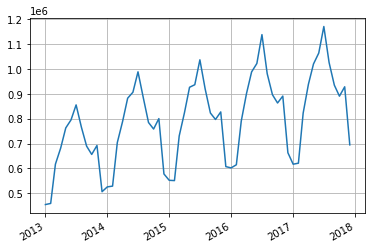

In [190]:
#plot monthly sales

#fig, ax = plt.subplots()
#ax.plot(df_sales['date'],df_sales['sales'])
#import matplotlib.dates as mdates

#years = mdates.YearLocator()

fig, ax = plt.subplots()
ax.plot('date','sales',data=df_sales)
fig.autofmt_xdate()
#ax.xaxis.set_major_locator(years)
ax.grid(True)
plt.show()

In [191]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0
6,2013-07-01,855922,795597.0,60325.0
7,2013-08-01,766761,855922.0,-89161.0
8,2013-09-01,689907,766761.0,-76854.0
9,2013-10-01,656587,689907.0,-33320.0
10,2013-11-01,692643,656587.0,36056.0


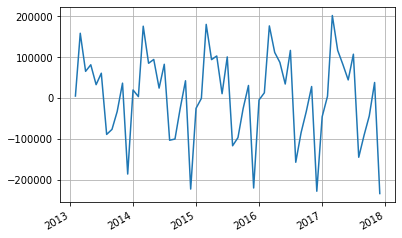

In [192]:
#plot the diff table
fig, ax = plt.subplots()
ax.plot('date','diff',data=df_diff)
fig.autofmt_xdate()
#ax.xaxis.set_major_locator(years)
ax.grid(True)
plt.show()

In [193]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

    #drop null values - 12 month lookup - remove dates with no 12 monthes lookup avalible
df_supervised = df_supervised.dropna().reset_index(drop=True)


In [194]:
#remove columns: sales and data
df_model = df_supervised.drop(['sales','date'],axis=1)

train_set, test_set = df_model[0:-6].values, df_model[-6:].values

print(df_model.shape)
print(train_set.shape)
print(test_set)

(47, 13)
(41, 13)
[[ 106769.   43938.   81824.  116195.  201298.    4063.  -46105. -228037.
    27811.  -33194.  -84663. -157224.  116054.]
 [-144990.  106769.   43938.   81824.  116195.  201298.    4063.  -46105.
  -228037.   27811.  -33194.  -84663. -157224.]
 [ -91140. -144990.  106769.   43938.   81824.  116195.  201298.    4063.
   -46105. -228037.   27811.  -33194.  -84663.]
 [ -44103.  -91140. -144990.  106769.   43938.   81824.  116195.  201298.
     4063.  -46105. -228037.   27811.  -33194.]
 [  37677.  -44103.  -91140. -144990.  106769.   43938.   81824.  116195.
   201298.    4063.  -46105. -228037.   27811.]
 [-233667.   37677.  -44103.  -91140. -144990.  106769.   43938.   81824.
   116195.  201298.    4063.  -46105. -228037.]]


In [195]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
#train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
#test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [196]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [197]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))


model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=500, batch_size=1, verbose=1, shuffle=False)

Epoch 1/500
41/41 [==============================] - 0s 3ms/step - loss: 0.2588
Epoch 2/500
41/41 [==============================] - 0s 3ms/step - loss: 0.2300
Epoch 3/500
41/41 [==============================] - 0s 4ms/step - loss: 0.2090
Epoch 4/500
41/41 [==============================] - 0s 3ms/step - loss: 0.1904
Epoch 5/500
41/41 [==============================] - 0s 3ms/step - loss: 0.1739
Epoch 6/500
41/41 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 7/500
41/41 [==============================] - 0s 2ms/step - loss: 0.1457
Epoch 8/500
41/41 [==============================] - 0s 2ms/step - loss: 0.1337
Epoch 9/500
41/41 [==============================] - 0s 2ms/step - loss: 0.1229
Epoch 10/500
41/41 [==============================] - 0s 2ms/step - loss: 0.1129
Epoch 11/500
41/41 [==============================] - 0s 2ms/step - loss: 0.1037
Epoch 12/500
41/41 [==============================] - 0s 2ms/step - loss: 0.0951
Epoch 13/500
41/41 [=================

In [198]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

print('pred' ,y_pred)
print('test',y_test)

pred [[ 0.5741674 ]
 [-0.7188357 ]
 [-0.34388408]
 [-0.07768774]
 [ 0.16420123]
 [-0.97507924]]
test [[ 0.55964922]
 [-0.61313659]
 [-0.36228353]
 [-0.14316792]
 [ 0.23779333]
 [-1.02622661]]


In [199]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    #print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)


In [200]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-7:].date)
act_sales = list(df_sales[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales

df_result

,pred_value,date
0,1174509,2017-07-01
1,1003712,2017-08-01
2,939212,2017-09-01
3,905216,2017-10-01
4,913039,2017-11-01
5,706149,2017-12-01


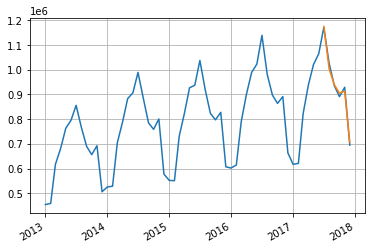

In [201]:
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')

#plot the diff table
fig, ax = plt.subplots()
ax.plot('date','sales',data=df_sales_pred)
ax.plot('date','pred_value',data=df_sales_pred)
fig.autofmt_xdate()
#ax.xaxis.set_major_locator(years)
ax.grid(True)
plt.show()